# Boosting Models from Scratch
### Bias-Variance Tradeoff and Sequential Error Correction 
Leo Bergmiller

This project investigates how boosting methods improve generalization performance compared to single decision trees.

We compare:

- Decision Trees (baseline)
- Gradient Boosting
- XGBoost
- LightGBM

The goal is to analyze how sequential learners reduce bias while controlling variance, and to visualize training dynamics through loss curves and feature importance. 

Dataset: Bank Marketing (UCI). (Note: If the CSV isn’t present locally, the notebook will download it automatically.)

## Imports

In [17]:
import os
import zipfile
import urllib.request
from pathlib import Path
import warnings 

# Core
import numpy as np
import pandas as pd

# Modeling
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder 
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Metrics + Plots
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score,
    precision_recall_curve, average_precision_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

# Boosting libraries
from xgboost import XGBClassifier 
from xgboost.callback import EarlyStopping
from lightgbm import LGBMClassifier 

RANDOM_STATE = 100
np.random.seed(RANDOM_STATE)

In [2]:
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

outer_zip = DATA_DIR / "bank-marketing.zip"

# 1) Download outer zip if missing
if not outer_zip.exists():
    print("Downloading dataset from UCI...")
    url = "https://archive.ics.uci.edu/static/public/222/bank+marketing.zip"
    urllib.request.urlretrieve(url, outer_zip)
    print("Downloaded to:", outer_zip.resolve())

# 2) Extract outer zip (may contain inner zips)
def extract_zip(zip_path: Path, dest_dir: Path) -> None:
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(dest_dir)

print("Extracting outer zip...")
extract_zip(outer_zip, DATA_DIR)

# 3) If bank-additional-full.csv still not present, extract inner zip(s)
csv_candidates = list(DATA_DIR.rglob("bank-additional-full.csv"))

if not csv_candidates:
    # Look for the inner zip (often bank-additional.zip)
    inner_zips = list(DATA_DIR.rglob("bank-additional.zip"))
    if inner_zips:
        print("Found inner zip:", inner_zips[0].resolve())
        print("Extracting inner bank-additional.zip...")
        extract_zip(inner_zips[0], DATA_DIR)
    else:
        # Fallback: extract any zip files found (safe for this dataset size)
        print("Did not find bank-additional.zip by name; extracting all .zip files in data/ ...")
        for z in DATA_DIR.rglob("*.zip"):
            if z.name != outer_zip.name:  # avoid re-extracting the outer zip
                try:
                    extract_zip(z, DATA_DIR)
                except zipfile.BadZipFile:
                    pass  # ignore non-zip or corrupted files

# 4) Locate the CSV again (after extracting inner zips)
csv_candidates = list(DATA_DIR.rglob("bank-additional-full.csv"))
if not csv_candidates:
    raise FileNotFoundError(
        "Could not locate bank-additional-full.csv after extraction. "
        "Try deleting the data/ folder and rerunning this cell."
    )

csv_path = csv_candidates[0]
print("Using CSV:", csv_path.resolve())

# 5) Read the CSV (it's semicolon-separated)
df = pd.read_csv(csv_path, sep=";")
df.head()

Extracting outer zip...
Using CSV: C:\Users\Gary\Documents\GitHub Projects\data\bank-additional\bank-additional-full.csv


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Quick EDA

In [3]:
print("Shape:", df.shape)
print("\nTarget distribution (y):")
print(df["y"].value_counts(normalize=True).rename("proportion"))

missing = df.isna().mean().sort_values(ascending=False)
print("\nTop missingness (fraction):")
display(missing.head(10))

Shape: (41188, 21)

Target distribution (y):
y
no     0.887346
yes    0.112654
Name: proportion, dtype: float64

Top missingness (fraction):


age            0.0
job            0.0
marital        0.0
education      0.0
default        0.0
housing        0.0
loan           0.0
contact        0.0
month          0.0
day_of_week    0.0
dtype: float64

### Preprossessing (Pre-Split)

In [4]:
df = df.copy()

# Drop duration to avoid unrealistic leakage
if "duration" in df.columns:
    df = df.drop(columns=["duration"])

# Create indicator for "never previously contacted"
# In this dataset, pdays == 999 means the client was not previously contacted.
if "pdays" in df.columns:
    df["new_contact"] = (df["pdays"] == 999).astype("int64")

    # Treat 999 as missing for the numeric pdays signal
    df.loc[df["pdays"] == 999, "pdays"] = np.nan

## Train / Validation / Test Split

70/15/15 split with stratification to preserve class proportions.

In [5]:
X = df.drop(columns=["y"])
y = (df["y"] == "yes").astype("int64")

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE, stratify=y_temp
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)
print("Train positive rate:", y_train.mean().round(4))
print("Val positive rate:", y_val.mean().round(4))
print("Test positive rate:", y_test.mean().round(4))

Train: (28831, 20) Val: (6178, 20) Test: (6179, 20)
Train positive rate: 0.1127
Val positive rate: 0.1127
Test positive rate: 0.1126


## Preprocessing (Post-Split)

In [6]:
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = [c for c in X_train.columns if c not in cat_cols]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

preprocess

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['age', 'campaign', 'pdays', 'previous',
                                  'emp.var.rate', 'cons.price.idx',
                                  'cons.conf.idx', 'euribor3m', 'nr.employed',
                                  'new_contact']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'month',
                                  'day_of_week', 'poutcome'])])

## Evaluation Helpers

In [7]:
def evaluate_binary_classifier(model, X, y, threshold=0.5):
    """Return common classification metrics + probability scores."""
    probs = model.predict_proba(X)[:, 1]
    preds = (probs >= threshold).astype(int)

    return {
        "accuracy": accuracy_score(y, preds),
        "precision": precision_score(y, preds, zero_division=0),
        "recall": recall_score(y, preds, zero_division=0),
        "f1": f1_score(y, preds, zero_division=0),
        "auc_pr": average_precision_score(y, probs),
        "auc_roc": roc_auc_score(y, probs),
        "probs": probs,
        "preds": preds
    }

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks([0,1], ["0", "1"])
    plt.yticks([0,1], ["0", "1"])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    plt.show()

def plot_pr_curve(y_true, probs, title="Precision–Recall Curve"):
    precision, recall, _ = precision_recall_curve(y_true, probs)
    ap = average_precision_score(y_true, probs)
    fig = plt.figure()
    plt.plot(recall, precision)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title} (AUC-PR={ap:.3f})")
    plt.show()

def plot_roc_curve(y_true, probs, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, probs)
    auc = roc_auc_score(y_true, probs)
    fig = plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title} (AUC={auc:.3f})")
    plt.show()

## Model 1: Decision Tree (Baseline)

In [8]:
dt_depths = [2, 3, 4, 5, 6, 8, 10, 12]
dt_results = []

for depth in dt_depths:
    dt = DecisionTreeClassifier(
        max_depth=depth,
        random_state=RANDOM_STATE
    )

    pipe = Pipeline(steps=[("prep", preprocess), ("model", dt)])

    param_dist = {
        "model__min_samples_split": [2, 5, 10, 20, 50],
        "model__ccp_alpha": np.linspace(0.0, 0.01, 11)
    }

    rs = RandomizedSearchCV(
        pipe,
        param_distributions=param_dist,
        n_iter=25,
        scoring="average_precision",
        cv=3,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=0
    )
    rs.fit(X_train, y_train)

    best = rs.best_estimator_
    tr = evaluate_binary_classifier(best, X_train, y_train)
    va = evaluate_binary_classifier(best, X_val, y_val)

    dt_results.append({
        "model": f"DecisionTree(depth={depth})",
        "depth": depth,
        "train_auc_pr": tr["auc_pr"],
        "val_auc_pr": va["auc_pr"],
        "train_f1": tr["f1"],
        "val_f1": va["f1"],
        "best_params": rs.best_params_
    })

dt_results_df = pd.DataFrame(dt_results).sort_values("val_auc_pr", ascending=False)
dt_results_df

,model,depth,train_auc_pr,val_auc_pr,train_f1,val_f1,best_params
3,DecisionTree(depth=5),5,0.439477,0.400691,0.401211,0.380762,"{'model__min_samples_split': 2, 'model__ccp_al..."
4,DecisionTree(depth=6),6,0.469726,0.399615,0.391430,0.345912,"{'model__min_samples_split': 2, 'model__ccp_al..."
2,DecisionTree(depth=4),4,0.412595,0.386121,0.328062,0.301676,"{'model__min_samples_split': 2, 'model__ccp_al..."
5,DecisionTree(depth=8),8,0.525056,0.385533,0.464204,0.375984,"{'model__min_samples_split': 2, 'model__ccp_al..."
1,DecisionTree(depth=3),3,0.381951,0.361400,0.313126,0.288636,"{'model__min_samples_split': 2, 'model__ccp_al..."
6,DecisionTree(depth=10),10,0.374215,0.360620,0.313126,0.288636,"{'model__min_samples_split': 5, 'model__ccp_al..."
7,DecisionTree(depth=12),12,0.374215,0.360620,0.313126,0.288636,"{'model__min_samples_split': 5, 'model__ccp_al..."
0,DecisionTree(depth=2),2,0.351753,0.337386,0.300701,0.283105,"{'model__min_samples_split': 5, 'model__ccp_al..."


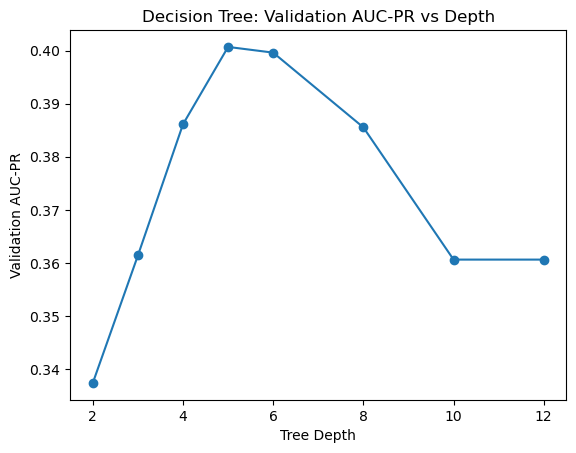

In [9]:
# Plot Decision Tree validation AUC-PR vs depth
plt.figure()
plt.plot(dt_results_df.sort_values("depth")["depth"], dt_results_df.sort_values("depth")["val_auc_pr"], marker="o")
plt.xlabel("Tree Depth")
plt.ylabel("Validation AUC-PR")
plt.title("Decision Tree: Validation AUC-PR vs Depth")
plt.show()

### Bias–Variance Interpretation

Validation AUC-PR peaks at depth 5. Shallower trees underfit (high bias), while deeper trees begin to overfit, as indicated by increasing training AUC but declining validation performance.

Interestingly, at very large depths (10–12), validation performance stabilizes again due to regularization (min_samples_split and cost-complexity pruning), which effectively limits tree growth despite high max_depth settings.

This illustrates how depth and regularization interact to control model complexity.

Best DT: DecisionTree(depth=5)
Best params: {'model__min_samples_split': 2, 'model__ccp_alpha': np.float64(0.0)} 



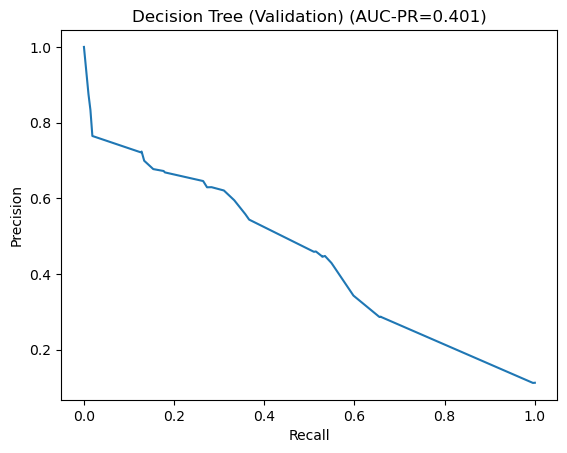

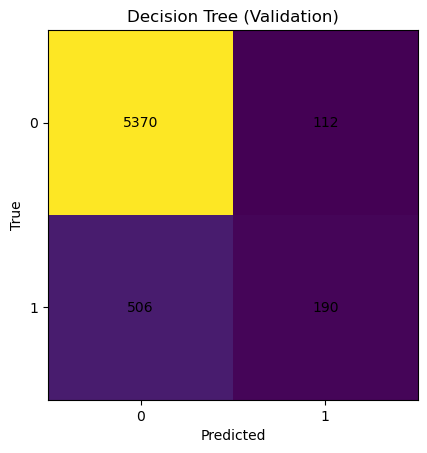

In [10]:
best_dt_row = dt_results_df.iloc[0]
best_dt_depth = int(best_dt_row["depth"])
print("Best DT:", best_dt_row["model"])
print("Best params:", best_dt_row["best_params"], "\n")

# Refit best DT with best params on train set
best_dt = Pipeline(steps=[
    ("prep", preprocess),
    ("model", DecisionTreeClassifier(max_depth=best_dt_depth, random_state=RANDOM_STATE))
])
best_dt.set_params(**best_dt_row["best_params"])
best_dt.fit(X_train, y_train)

dt_val = evaluate_binary_classifier(best_dt, X_val, y_val)
plot_pr_curve(y_val, dt_val["probs"], title="Decision Tree (Validation)")
plot_confusion_matrix(y_val, dt_val["preds"], title="Decision Tree (Validation)")

## Model 2: Gradient Boosting 

We tune key hyperparameters and inspect staged performance across boosting iterations.

Best GB params: {'model__subsample': 1.0, 'model__n_estimators': 200, 'model__max_depth': 3, 'model__learning_rate': 0.05}


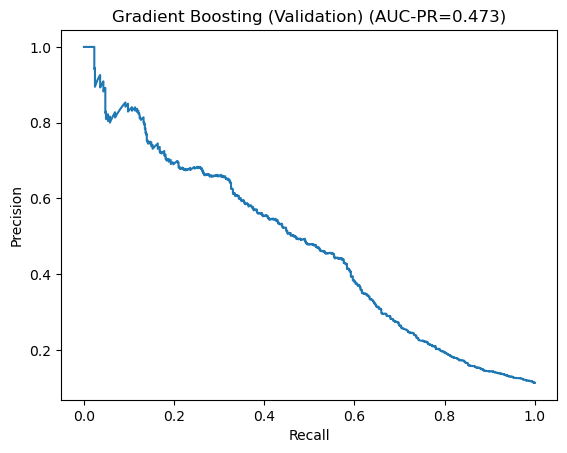

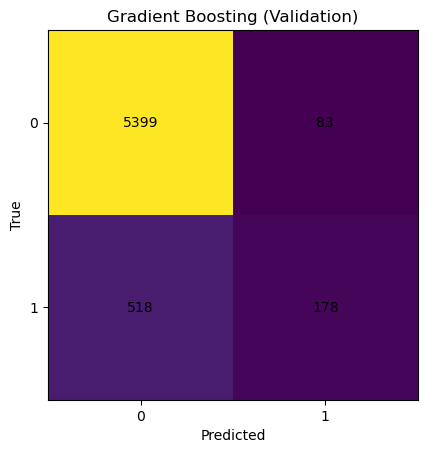

In [11]:
gb = GradientBoostingClassifier(random_state=RANDOM_STATE)

gb_pipe = Pipeline(steps=[("prep", preprocess), ("model", gb)])

gb_param_dist = {
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
    "model__n_estimators": [100, 200, 400, 600],
    "model__max_depth": [1, 2, 3],
    "model__subsample": [0.6, 0.8, 1.0]
}

gb_rs = RandomizedSearchCV(
    gb_pipe,
    param_distributions=gb_param_dist,
    n_iter=30,
    scoring="average_precision",
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

gb_rs.fit(X_train, y_train)
best_gb = gb_rs.best_estimator_
print("Best GB params:", gb_rs.best_params_, "\n")

gb_val = evaluate_binary_classifier(best_gb, X_val, y_val)
plot_pr_curve(y_val, gb_val["probs"], title="Gradient Boosting (Validation)")
plot_confusion_matrix(y_val, gb_val["preds"], title="Gradient Boosting (Validation)")

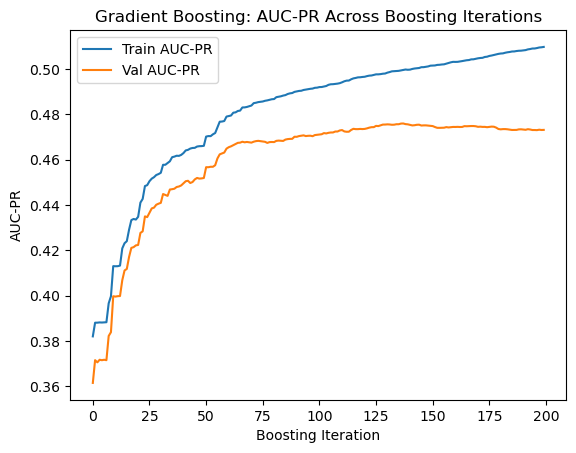

In [12]:
# Extract fitted components
gb_model = best_gb.named_steps["model"]
gb_prep = best_gb.named_steps["prep"]

X_train_enc = gb_prep.transform(X_train)
X_val_enc = gb_prep.transform(X_val)

val_auc_pr_by_stage = []
train_auc_pr_by_stage = []

# staged_predict_proba yields predictions after each boosting stage
for train_probs, val_probs in zip(gb_model.staged_predict_proba(X_train_enc), gb_model.staged_predict_proba(X_val_enc)):
    train_auc_pr_by_stage.append(average_precision_score(y_train, train_probs[:, 1]))
    val_auc_pr_by_stage.append(average_precision_score(y_val, val_probs[:, 1]))

plt.figure()
plt.plot(train_auc_pr_by_stage, label="Train AUC-PR")
plt.plot(val_auc_pr_by_stage, label="Val AUC-PR")
plt.xlabel("Boosting Iteration")
plt.ylabel("AUC-PR")
plt.title("Gradient Boosting: AUC-PR Across Boosting Iterations")
plt.legend()
plt.show()

## Model 3: XGBoost 

XGBoost provides built-in tracking of training and validation metrics at each boosting round. We use early stopping to prevent overfitting.

In [19]:
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1
)

xgb_pipe = Pipeline(steps=[("prep", preprocess), ("model", xgb)])

xgb_param_dist = {
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "model__max_depth": [2, 3, 4, 5],
    "model__n_estimators": [300, 600, 1000],
    "model__subsample": [0.6, 0.8, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0],
    "model__reg_lambda": [0.5, 1.0, 2.0, 5.0],
    "model__min_child_weight": [1, 5, 10]
}

xgb_rs = RandomizedSearchCV(
    xgb_pipe,
    param_distributions=xgb_param_dist,
    n_iter=25,
    scoring="average_precision",
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)
xgb_rs.fit(X_train, y_train)
best_xgb = xgb_rs.best_estimator_
print("Best XGB params:", xgb_rs.best_params_)

Best XGB params: {'model__subsample': 0.6, 'model__reg_lambda': 5.0, 'model__n_estimators': 300, 'model__min_child_weight': 5, 'model__max_depth': 4, 'model__learning_rate': 0.05, 'model__colsample_bytree': 1.0}


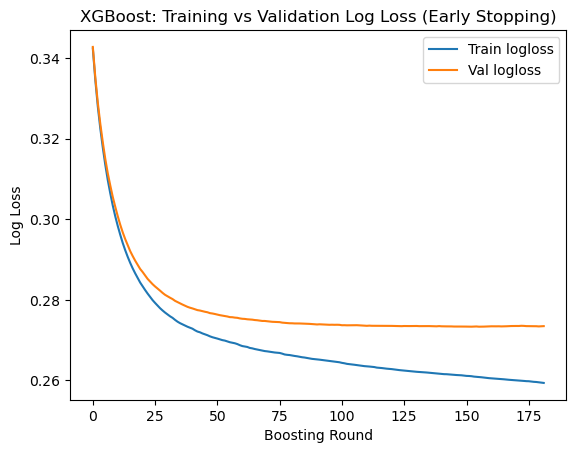

In [23]:
# Refit best XGB with eval tracking + early stopping
# Note: Pipeline makes it harder to pass eval_set; we fit preprocess separately for this diagnostic plot.
prep_fitted = preprocess.fit(X_train)  # fit on train only
X_train_enc = prep_fitted.transform(X_train)
X_val_enc = prep_fitted.transform(X_val)

best_params = {k.replace("model__", ""): v for k, v in xgb_rs.best_params_.items()}

xgb_diag = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=RANDOM_STATE,
    n_jobs=-1, 
    early_stopping_rounds=25, 
    **best_params
)

xgb_diag.fit(
    X_train_enc, y_train,
    eval_set=[(X_train_enc, y_train), (X_val_enc, y_val)],
    verbose=False,
)

evals = xgb_diag.evals_result()
train_logloss = evals["validation_0"]["logloss"]
val_logloss = evals["validation_1"]["logloss"]

plt.figure()
plt.plot(train_logloss, label="Train logloss")
plt.plot(val_logloss, label="Val logloss")
plt.xlabel("Boosting Round")
plt.ylabel("Log Loss")
plt.title("XGBoost: Training vs Validation Log Loss (Early Stopping)")
plt.legend()
plt.show()

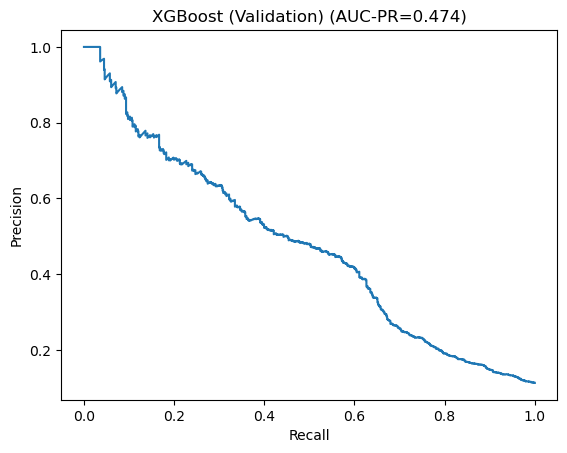

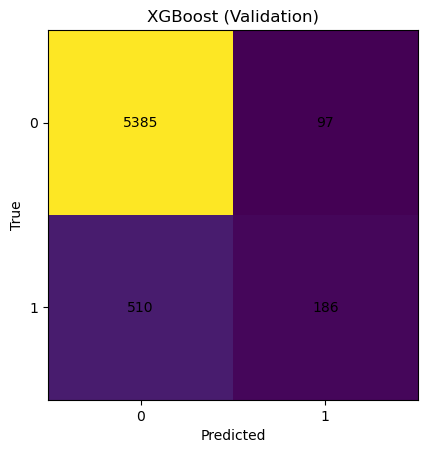

In [24]:
# Final XGB model via pipeline (for consistent evaluation)
best_xgb.fit(X_train, y_train)
xgb_val = evaluate_binary_classifier(best_xgb, X_val, y_val)

plot_pr_curve(y_val, xgb_val["probs"], title="XGBoost (Validation)")
plot_confusion_matrix(y_val, xgb_val["preds"], title="XGBoost (Validation)")

## Model 4: LightGBM 

Bonus comparison with XGBoost

Best LGBM params: {'model__subsample': 0.8, 'model__num_leaves': 31, 'model__n_estimators': 300, 'model__learning_rate': 0.01, 'model__colsample_bytree': 0.6}


C:\Users\Gary\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


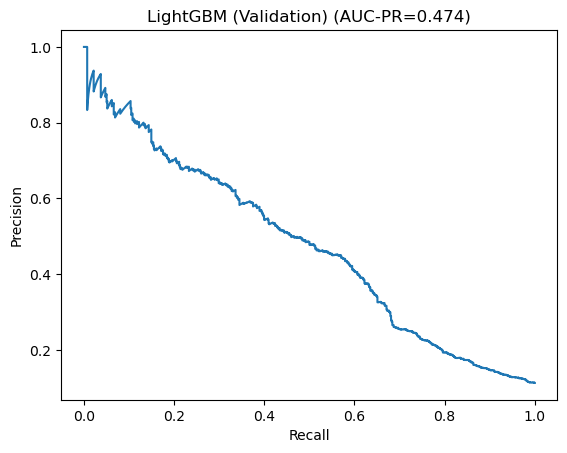

In [27]:
lgbm = LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
lgbm_pipe = Pipeline(steps=[("prep", preprocess), ("model", lgbm)])

lgbm_param_dist = {
    "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "model__n_estimators": [300, 600, 1000],
    "model__num_leaves": [31, 63, 127],
    "model__subsample": [0.6, 0.8, 1.0],
    "model__colsample_bytree": [0.6, 0.8, 1.0]
}

lgbm_rs = RandomizedSearchCV(
    lgbm_pipe,
    param_distributions=lgbm_param_dist,
    n_iter=20,
    scoring="average_precision",
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
lgbm_rs.fit(X_train, y_train)
best_lgbm = lgbm_rs.best_estimator_
print("Best LGBM params:", lgbm_rs.best_params_)

lgbm_val = evaluate_binary_classifier(best_lgbm, X_val, y_val)
plot_pr_curve(y_val, lgbm_val["probs"], title="LightGBM (Validation)")

## Final Evaluation & Comparison on Test Set

In [28]:
# Evaluate selected models on test (trained on train only)
models = {
    "Decision Tree": best_dt,
    "Gradient Boosting": best_gb,
    "XGBoost": best_xgb, 
    "LightGBM": best_lgbm
}

rows = []
test_probs = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    te = evaluate_binary_classifier(model, X_test, y_test)
    rows.append({
        "model": name,
        "accuracy": te["accuracy"],
        "precision": te["precision"],
        "recall": te["recall"],
        "f1": te["f1"],
        "auc_pr": te["auc_pr"],
        "auc_roc": te["auc_roc"]
    })
    test_probs[name] = (te["probs"], te["preds"])

results = pd.DataFrame(rows).sort_values("auc_pr", ascending=False)
results

C:\Users\Gary\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,model,accuracy,precision,recall,f1,auc_pr,auc_roc
2,XGBoost,0.898204,0.620072,0.248563,0.354872,0.456124,0.798154
3,LightGBM,0.897718,0.625000,0.229885,0.336134,0.448820,0.800659
1,Gradient Boosting,0.896747,0.616935,0.219828,0.324153,0.444510,0.791973
0,Decision Tree,0.896585,0.594059,0.258621,0.360360,0.388128,0.756206


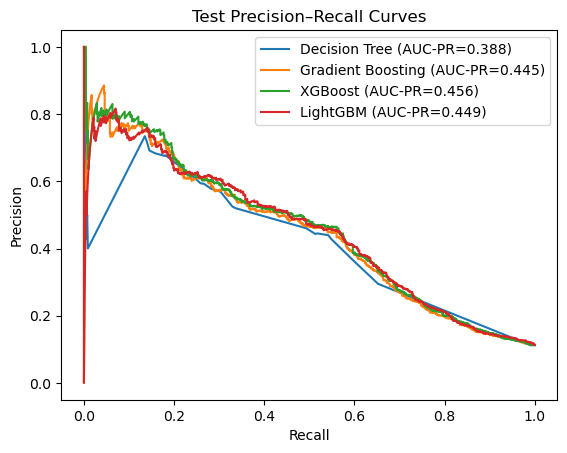

In [29]:
# Plot PR curves for all models on test
plt.figure()
for name, (probs, _) in test_probs.items():
    precision, recall, _ = precision_recall_curve(y_test, probs)
    ap = average_precision_score(y_test, probs)
    plt.plot(recall, precision, label=f"{name} (AUC-PR={ap:.3f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Test Precision–Recall Curves")
plt.legend()
plt.show()

## Discussion

#### Why Boosting Improves Performance

Across all evaluation metrics, boosting methods (Gradient Boosting, XGBoost, LightGBM) substantially outperform a single Decision Tree baseline in terms of AUC-PR. 

The Decision Tree achieves an AUC-PR of 0.388, while XGBoost improves this to 0.456 — a meaningful relative gain in ranking performance. This improvement arises because boosting builds an additive ensemble of weak learners, sequentially correcting residual errors from prior trees. Instead of relying on one high-variance structure, the ensemble gradually refines decision boundaries.

#### Bias–Variance Perspective

The Decision Tree demonstrates classic variance behavior: it can achieve reasonable F1 at a specific threshold but struggles with probability ranking quality, as reflected by lower AUC-PR.

Boosting reduces bias early by adding weak learners, while regularization mechanisms (learning rate, subsampling, depth constraints, and early stopping diagnostics) prevent uncontrolled variance growth. The staged training curves show that validation performance improves rapidly in early rounds before stabilizing — indicating controlled capacity growth.

#### Interpreting the Precision–Recall Curves

The PR curves reveal consistent dominance of boosting methods across most recall levels. XGBoost provides the strongest precision at moderate recall values (0.1–0.5), which is often the most operationally relevant region in imbalanced classification problems.

Although ROC-AUC values are relatively close across boosting models (~0.79–0.80), AUC-PR provides clearer separation. This highlights an important practical lesson:

> In imbalanced classification settings, ROC-AUC can obscure meaningful performance differences that PR curves reveal.

#### Comparing Boosting Frameworks

- **XGBoost** achieves the highest AUC-PR (0.456), likely benefiting from stronger regularization controls (`reg_lambda`, `min_child_weight`) and column sampling.
- **LightGBM** performs similarly (0.449 AUC-PR), suggesting comparable bias reduction but slightly different tree growth dynamics.
- **Gradient Boosting (sklearn)** performs competitively but lacks some of the advanced regularization mechanisms available in XGBoost and LightGBM.

The differences between boosting frameworks are incremental rather than dramatic — all significantly outperform the single-tree baseline.

#### Practical Takeaways

- Boosting methods provide clear gains in ranking quality for rare-event prediction.
- Monitoring validation curves across boosting rounds is critical to detecting overfitting.
- AUC-PR is the appropriate evaluation metric for imbalanced datasets like this one.
- Regularization (learning rate, subsampling, depth limits) is as important as model complexity.

Overall, boosting provides a controlled mechanism for bias reduction while managing variance through shrinkage and sampling — leading to improved generalization performance.